In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 558 µs


In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop

time: 5.42 s


# Loading data

In [3]:
def load_data(no_of_images):
    
    img_size = (128,128)
    imgs_source = []
    imgs_target = []
    
    dir_source = "../input/xray-bone-shadow-supression/augmented/augmented/source"
    dir_target = "../input/xray-bone-shadow-supression/augmented/augmented/target"
    
    i = 0
    for _, _, filenames in os.walk('/kaggle/input/xray-bone-shadow-supression/augmented/augmented/source/'):
        for filename in filenames:
            i = i+1
            if(i > no_of_images):
                break
            img_source = cv2.imread(os.path.join(dir_source,filename),cv2.IMREAD_GRAYSCALE)
            img_target = cv2.imread(os.path.join(dir_target, filename),cv2.IMREAD_GRAYSCALE)
            # resizing images
            img_source = cv2.resize(img_source,img_size)
            img_target = cv2.resize(img_target,img_size)
            # normalizing images
            img_source = np.array(img_source)/255
            img_target = np.array(img_target)/255
            
            imgs_source.append(img_source)
            imgs_target.append(img_target)
    return imgs_source, imgs_target

time: 2.91 ms


In [4]:
source, target = load_data(1000)

time: 43.9 s


Let's see some of the source images and their corresponding targets.

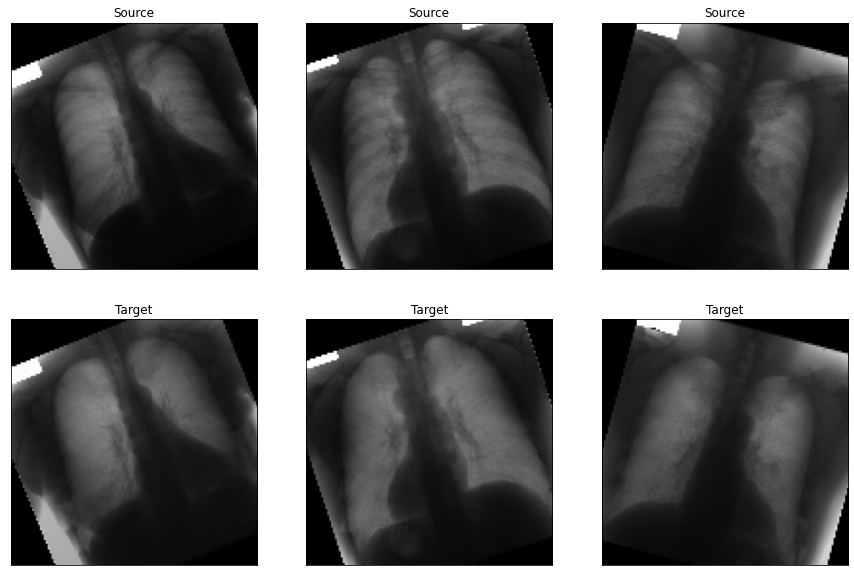

time: 511 ms


In [5]:
plt.figure(figsize=(15,10))

for i in range(3):
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(source[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source')

    ax = plt.subplot(2, 3, i+4)
    plt.imshow(target[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')
plt.show()

Reshaping and Spliting the Data 

In [6]:
img_rows = 128
img_cols = 128
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)

source = np.array(source).reshape(-1, img_rows, img_cols, img_channels)
target = np.array(target).reshape(-1, img_rows, img_cols, img_channels)

source_train, source_test, target_train, target_test = train_test_split(source, target,
                                                                        test_size=0.20,
                                                                        random_state=1)

time: 151 ms


In [7]:
print(source_train.shape, source_test.shape, target_train.shape, target_test.shape)

(800, 128, 128, 1) (200, 128, 128, 1) (800, 128, 128, 1) (200, 128, 128, 1)
time: 1.33 ms


# Defining the Autoencoder Model

In [8]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) 
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) 
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) 
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded

time: 8.85 ms


In [9]:
input_img = Input(shape = img_shape)
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

time: 3.01 s


In [10]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)       

In [11]:
n_epoch = 200
n_batch = 128
autoencoder_train = autoencoder.fit(source_train, target_train,
                                    epochs = n_epoch,
                                    batch_size = n_batch,
                                    verbose = 0,
                                    validation_data = (source_test, target_test))

time: 3min 19s


In [12]:
interval_epochs = [0, 49,99,149,199]
for e in interval_epochs:
    print("epoch = {}\tLoss = {:.5f}\tValidation_Loss = {:.5f}".format(e+1,autoencoder_train.history['loss'][e],autoencoder_train.history['val_loss'][e]))

epoch = 1	Loss = 0.12950	Validation_Loss = 0.09009
epoch = 50	Loss = 0.00252	Validation_Loss = 0.01424
epoch = 100	Loss = 0.00157	Validation_Loss = 0.00253
epoch = 150	Loss = 0.00120	Validation_Loss = 0.00267
epoch = 200	Loss = 0.00117	Validation_Loss = 0.00151
time: 1.37 ms


Now, let's plot the train and validation losses to visualise the model performance.

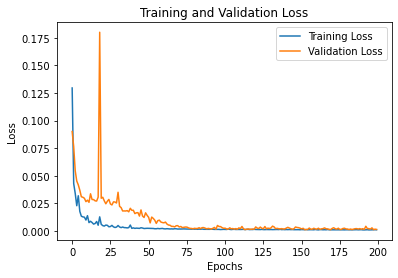

time: 194 ms


In [13]:
n = np.arange(0, n_epoch)
plt.figure()
plt.plot(n, autoencoder_train.history['loss'], label = 'Training Loss')
plt.plot(n, autoencoder_train.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Predicting on Validation data

In [14]:
pred = autoencoder.predict(source_test)

time: 759 ms


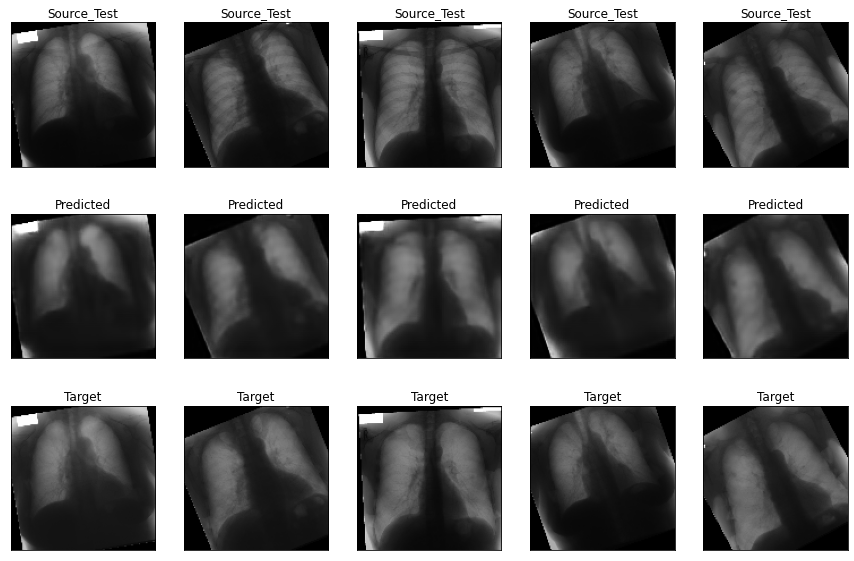

time: 806 ms


In [15]:
plt.figure(figsize=(15,10))

for i in range(5):
    ax = plt.subplot(3, 5, i+1)
    plt.imshow(source_test[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source_Test')

    ax = plt.subplot(3, 5, i+6)
    plt.imshow(pred[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Predicted')
    
    ax = plt.subplot(3, 5, i+11)
    plt.imshow(target_test[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')
plt.show()